In [1]:

import numpy as np

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential

import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/single_pendulum.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


In [22]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 600
n_frames = 30
row = 128
col = 128
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float)

source_directory = "/tmp/single_pendulum"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(n_frames):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # resize the image to 128x128
            img_resized = cv2.resize(img, (row, col))

            # convert the image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            
            #GOING TO REMOVE BACKGROUND
            # apply threshold to create a binary mask. Pixel's above 200 become white, below become black
            _, binary_mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)

            # invert the binary mask (white -> black. Correspond to bkg)
            inverted_mask = cv2.bitwise_not(binary_mask)

            # set all pixels to 0 where the mask is black
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # NORMALIZE IMAGE
            img_normalized = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
            img_normalized = img_normalized / 255.0

            # SALT AND PEPPER NOISE
            # img_noisy = random_noise(img_normalized, mode='s&p', amount=0.05)

            # assign the processed image to the dataset
            dataset[folder_num][idx] = img_normalized

In [23]:
dataset = dataset[..., np.newaxis]
dataset.shape

(600, 30, 128, 128, 1)

In [24]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]


In [25]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten

seq = Sequential()

seq.add(ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

# Attempts to add Attention Layer (Not actually implemented properly)
attention = Attention()
conv_lstm_output = seq.get_layer(index=-2).output
attention_result = attention([conv_lstm_output, conv_lstm_output])
pooled_attention = GlobalAveragePooling3D()(attention_result)
flattened_conv_lstm = Flatten()(conv_lstm_output)
reshaped_attention = Reshape((1, 1, 64))(pooled_attention)
flattened_attention = Flatten()(reshaped_attention)
combined = concatenate([flattened_conv_lstm, flattened_attention])

# final Conv3D layer (apply sigmoid activation for prediction, 1 channel for B/W channel)
seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


Epoch 1/15
1/1 [==============================] - 0s 149ms/step


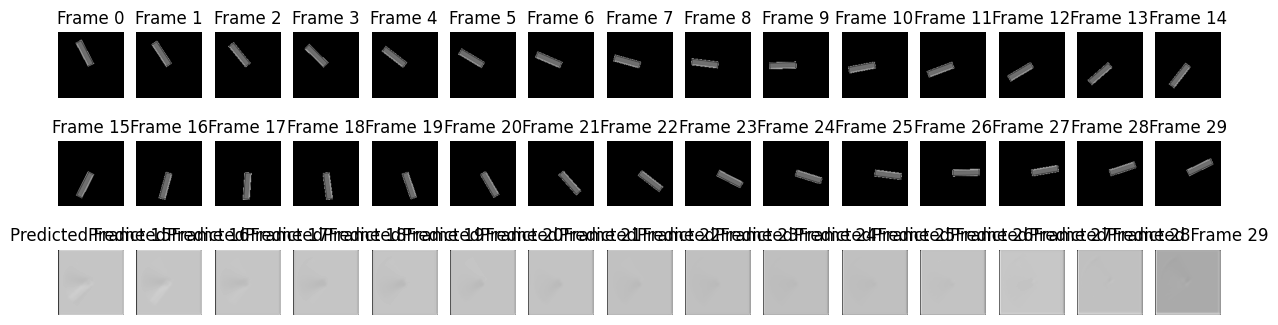

270/270 [==============================] - 160s 565ms/step - loss: 0.1206 - accuracy: 0.9365 - val_loss: 0.0949 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 0s 147ms/step


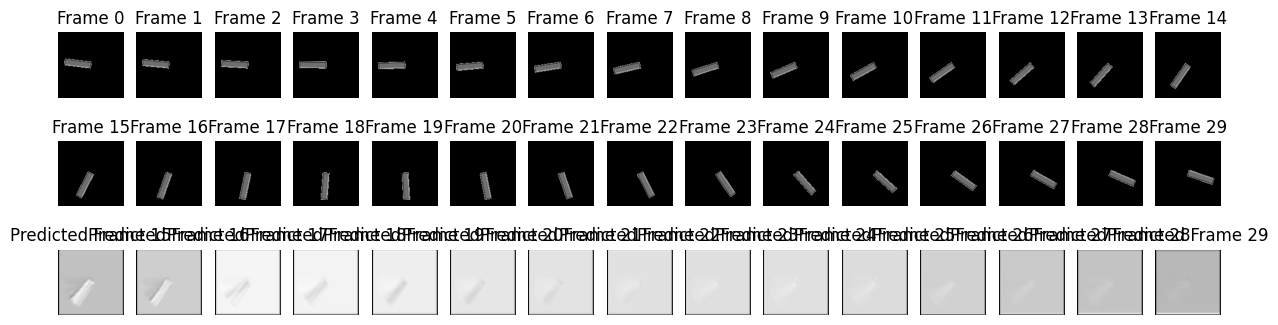

270/270 [==============================] - 150s 555ms/step - loss: 0.0306 - accuracy: 0.9576 - val_loss: 0.0472 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 0s 147ms/step


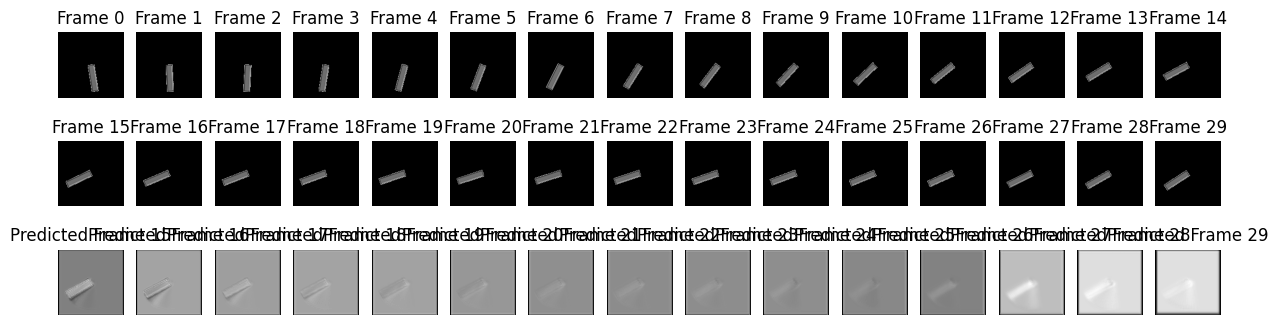

270/270 [==============================] - 150s 555ms/step - loss: 0.0277 - accuracy: 0.9576 - val_loss: 0.0305 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 0s 148ms/step


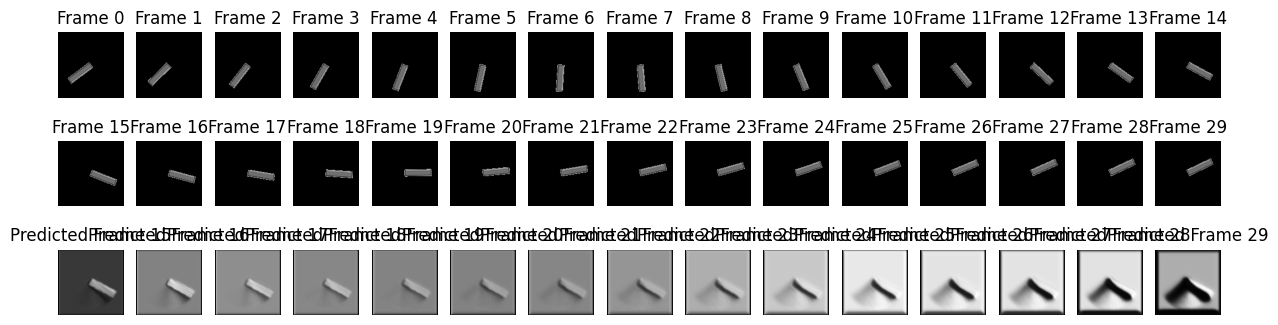

270/270 [==============================] - 153s 566ms/step - loss: 0.0273 - accuracy: 0.9576 - val_loss: 0.0273 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 5/15
1/1 [==============================] - 0s 150ms/step


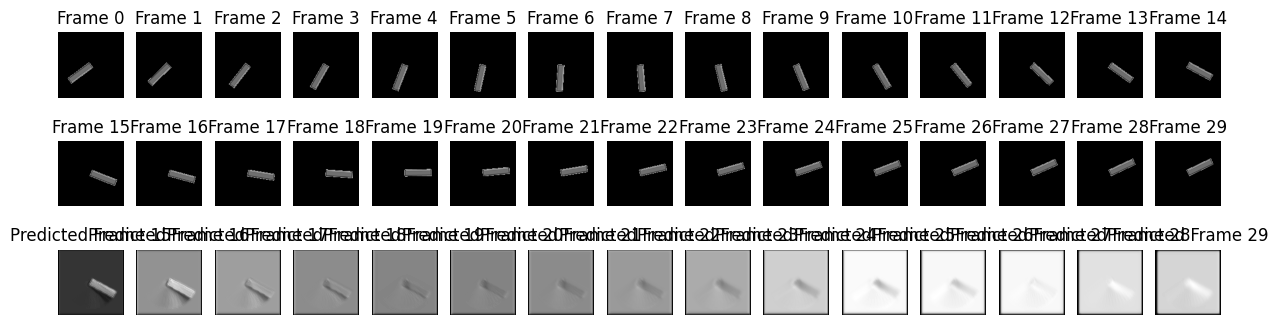

270/270 [==============================] - 150s 555ms/step - loss: 0.0266 - accuracy: 0.9576 - val_loss: 0.0266 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 6/15
1/1 [==============================] - 0s 149ms/step


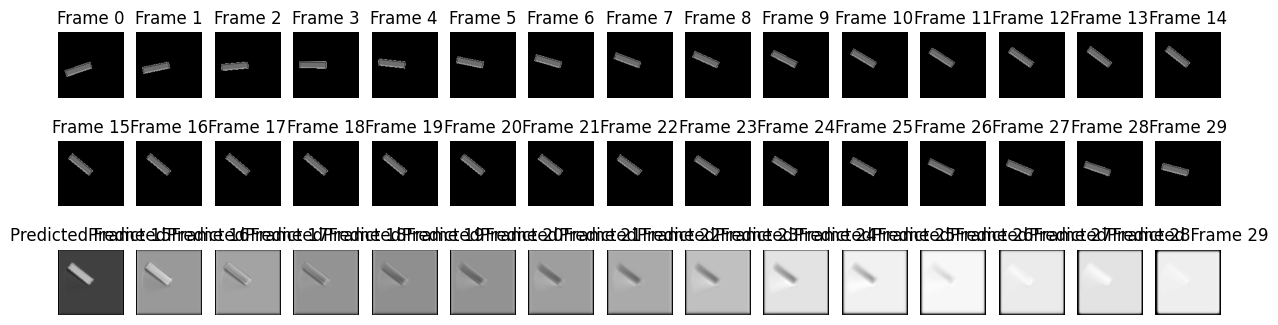

270/270 [==============================] - 150s 557ms/step - loss: 0.0265 - accuracy: 0.9576 - val_loss: 0.0264 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 7/15
1/1 [==============================] - 0s 150ms/step


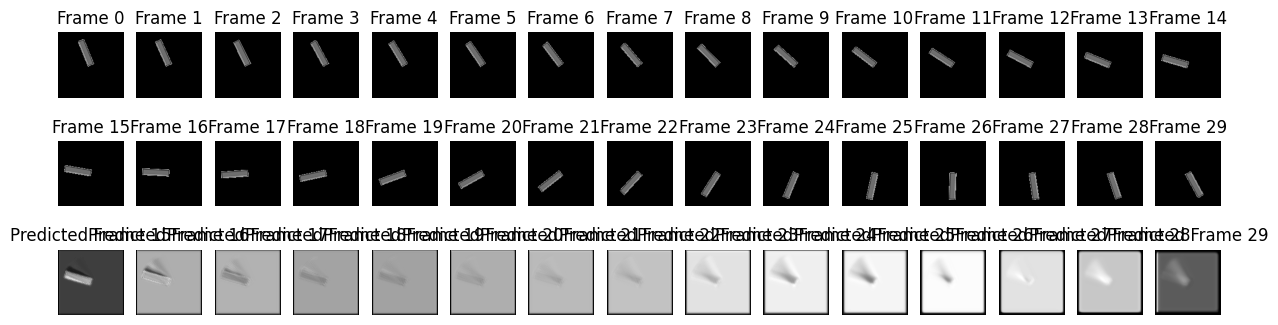

270/270 [==============================] - 150s 554ms/step - loss: 0.0265 - accuracy: 0.9576 - val_loss: 0.0551 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 8/15
1/1 [==============================] - 0s 150ms/step


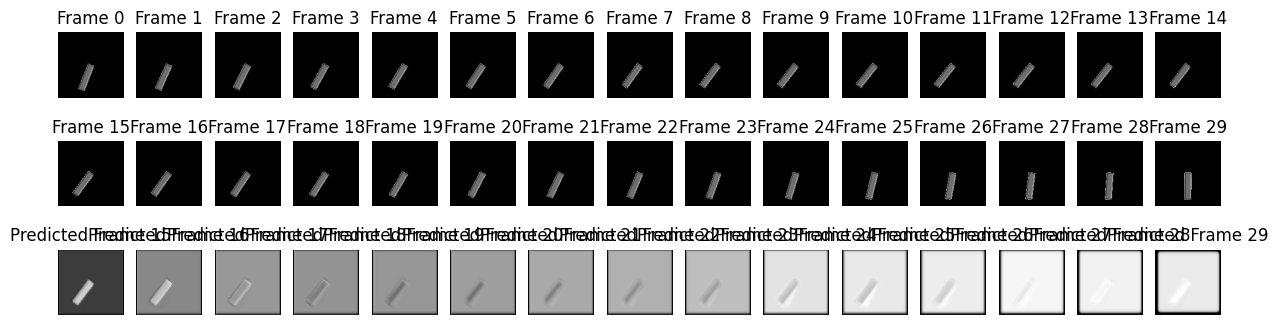

270/270 [==============================] - 150s 557ms/step - loss: 0.0264 - accuracy: 0.9576 - val_loss: 0.0267 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 9/15
1/1 [==============================] - 0s 149ms/step


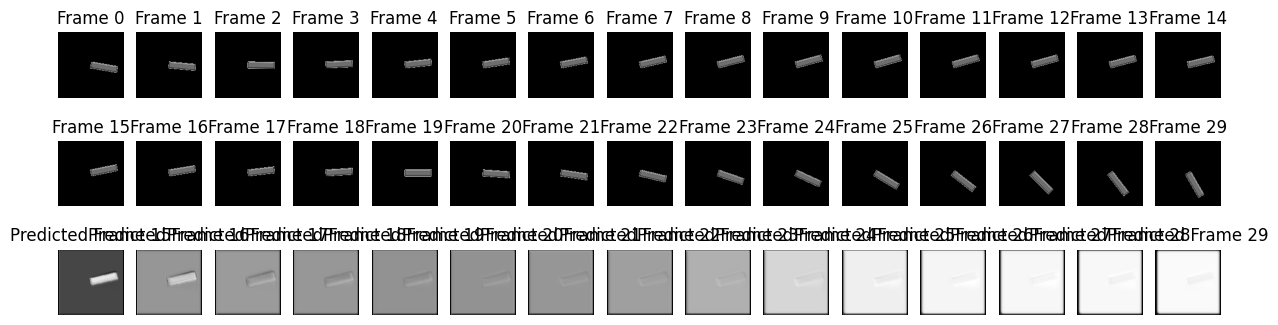

270/270 [==============================] - 150s 555ms/step - loss: 0.0265 - accuracy: 0.9576 - val_loss: 0.0272 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 10/15
1/1 [==============================] - 0s 149ms/step


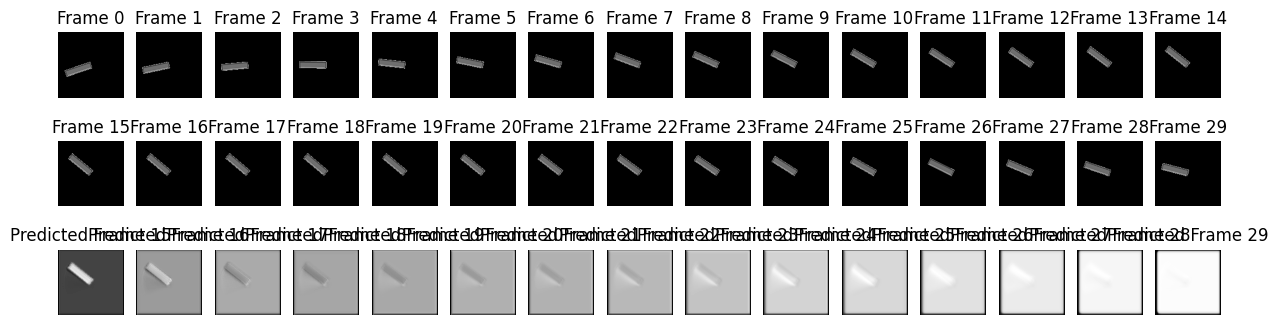

270/270 [==============================] - 150s 554ms/step - loss: 0.0263 - accuracy: 0.9576 - val_loss: 0.0265 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 11/15
1/1 [==============================] - 0s 147ms/step


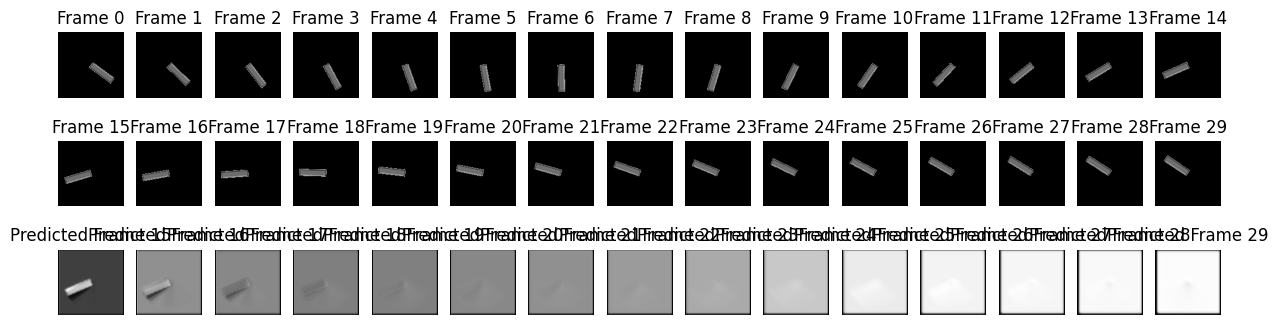

270/270 [==============================] - 150s 557ms/step - loss: 0.0264 - accuracy: 0.9576 - val_loss: 0.0272 - val_accuracy: 0.9576 - lr: 0.0010


In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

half_imgs = int(30/2)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 15
batch_size = 1

class PrintPredictionCallback(Callback):
    def __init__(self, dataset, half_imgs):
        super(PrintPredictionCallback, self).__init__()
        self.dataset = dataset
        self.half_imgs = half_imgs

    def on_epoch_end(self, epoch, logs=None):
        # select a random example from the testing dataset
        example = self.dataset[random.randrange(301, 599)]

        # pick the first/last 15 frames from the example
        frames = example[:self.half_imgs, ...]  # First 15
        original_frames = example[self.half_imgs:, ...]  # Last 15
        ogog_frames = example[:self.half_imgs, ...]  # First 15, unadulterated

        # predict next 15 frames
        for _ in range(self.half_imgs):
             # extract model's prediction and process it
            new_prediction = self.model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, self.half_imgs, figsize=(self.half_imgs, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx}")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx + self.half_imgs}")
            ax.axis("off")

        # plot the new frames.
        new_frames = frames[self.half_imgs:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"Predicted Frame {idx + self.half_imgs}")
            ax.axis("off")

        # display the figure.
        plt.show()

# create instance of custom callback function to print images at end of epoch
print_prediction_callback = PrintPredictionCallback(dataset, half_imgs)

# training
seq.fit(X[:300], y[:300], batch_size=1,
        epochs=epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr, print_prediction_callback])


In [29]:
import random
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap


# create a PDF to save figures
with PdfPages('/output_frames_v17.pdf') as pdf:
    for i in range(30):
        # select a random example from the testing dataset
        example = dataset[random.randrange(301, 599)]

        # pick the first/last 15 frames from the example
        frames = example[:15, ...]  # first 15
        original_frames = example[15:, ...]  # last 15
        ogog_frames = example[:15, ...]  # first 15, unadulterated

        # predict next 15 frames.
        for _ in range(15):
            # extract model's prediction and process it
            new_prediction = model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, 15, figsize=(30, 4))

        # plot the original frames
        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx}")
            ax.axis("off")
        #plot ground truth frames
        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx + 15}")
            ax.axis("off")

        # plot predicted frames
        new_frames = frames[15:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"P Frame {idx + 15}")
            ax.axis("off")

        # save figure
        pdf.savefig()
        plt.close()

1/1 [==============================] - 0s 148ms/step
